In [1]:
# For sending GET requests from the API
import requests
# For saving access tokens and for file management when creating and adding to the dataset
import os
# For dealing with json responses we receive from the API
import json
# For displaying the data after
import numpy as np
import pandas as pd
# For saving the response data in CSV format
import csv
# For parsing the dates received from twitter in readable formats
import datetime
import dateutil.parser
import unicodedata
#To add wait time between requests
import time
#Imports timer
import tqdm
#To do Regex
import re
#To do sentiment analysis
from textblob import TextBlob

import matplotlib.pyplot as plt 
import seaborn as sns

## Import data from CSV file to a DataFrame

In [2]:
data_df = pd.read_csv('final dataset twt.csv')

## Cleaning up DataFrame

### Adding columns

In [3]:
#Add date and hour columns:
data_df['Date'] = pd.to_datetime(data_df['Date Created']).dt.date
data_df['Hour'] = pd.to_datetime(data_df['Date Created']).dt.hour

clean_df = data_df.drop('Unnamed: 0', axis=1)

### Removing columns

### Sample

In [6]:
clean_df

,User,Date Created,Number of Likes,Tweet,Date,Hour
0,DogecoinCuban,2021-12-31 23:59:58+00:00,1,@Rodolfo07351753 @sodogetip tip @Rodolfo073517...,2021-12-31,23
1,RNY1117,2021-12-31 23:59:47+00:00,2,HAPPY NEW DOGE YEAR,2021-12-31,23
2,bojodus,2021-12-31 23:59:37+00:00,0,"Prayers Up for XRP, DOGE , SHIB \nx1000 to the...",2021-12-31,23
3,CryptoCapflow,2021-12-31 23:59:09+00:00,0,"[Spot] By 2021-12-31 14:00 GMT, DOGE total tra...",2021-12-31,23
4,CarlosS74671189,2021-12-31 23:59:04+00:00,1,@Darlene_Pizarro How much Doge would you like ...,2021-12-31,23
...,...,...,...,...,...,...
1194430,FraxinusE,2021-10-20 15:16:21+00:00,0,@RichAvatar_ Doge,2021-10-20,15
1194431,realDogecoinOG,2021-10-20 15:16:19+00:00,4,Chart of Open Interests or the huge pump on pe...,2021-10-20,15
1194432,jalantrading,2021-10-20 15:16:13+00:00,0,DOGE https://t.co/jmoMMslmTs,2021-10-20,15
1194433,LeviKrull,2021-10-20 15:16:05+00:00,0,Bought a doge miner with doge today,2021-10-20,15


## Some initial plotting

In [8]:
tweets_per_day_df = clean_df['Tweet'].groupby(clean_df['Date']).count()

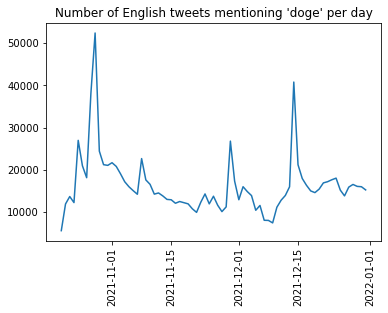

In [9]:
plt.plot(tweets_per_day_df)
plt.title('Number of English tweets mentioning \'doge\' per day')
plt.xticks(rotation=90)

plt.show()

# Sentiment analysis

First we define two functions:
* One that cleans a given tweet for unnecessary stuff, such as mentions etc
* One that uses the TextBlob library's sentiment function to determine a given tweets sentiment

In [10]:
def clean_tweet(tweet):
    '''
    Using RegEx, this function cleans the tweets for unnecessary fluffer
    '''
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())

def get_tweet_sentiment(tweet):
    '''
    Uses textblob to decide sentiment of a parsed tweet
    '''
    # Create TextBlob object
    blob = TextBlob(clean_tweet(tweet))
        
    # Set sentiment
    if blob.sentiment.polarity > 0:
        return 'positive'
    elif blob.sentiment.polarity == 0:
        return 'neutral'
    else:
        return 'negative'

### Demonstration of the clean_tweet function:

In [11]:
#print('Full tweet: \n',clean_df['text'][0], '\n')

#print('Cleaned tweet: \n',clean_tweet(clean_df['text'][0]))

## Adding a sentiment-column

Using list comprehension we use the above defined functions on each tweet text in clean_df

### OBS: the cell takes around 5 minutes to run

In [12]:
clean_df['Sentiment'] = [get_tweet_sentiment(tweet) for tweet in tqdm.tqdm(clean_df['Tweet'])]

100%|██████████████████████████████████████████████████████████████████████| 1194435/1194435 [09:11<00:00, 2166.23it/s]


In [14]:
sentiment_dict = {
  "negative": -1,
  "neutral": 0,
  "positive": 1}

clean_df['Numerical'] = [sentiment_dict[i] for i in clean_df['Sentiment']]

In [20]:
clean_df.to_csv('Cleaned_Twitter_Scrape_10-12_2021.csv')

### Grouping by sentiment, for simple bar chart

In [18]:
tweets_by_sentiment = clean_df['Tweet'].groupby(clean_df['Sentiment']).count()

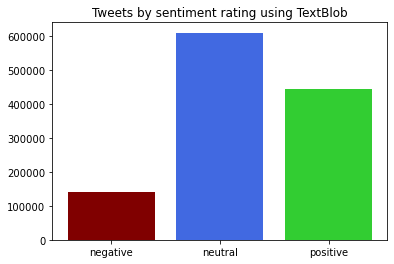

In [19]:
plt.bar(['negative', 'neutral', 'positive'], tweets_by_sentiment, color =['maroon','royalblue','limegreen'])
plt.title('Tweets by sentiment rating using TextBlob')

plt.show()

In [21]:
sentiment_per_day_df = clean_df['Numerical'].groupby(clean_df['Date']).sum()

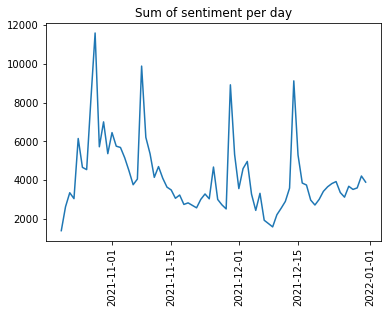

In [22]:
plt.plot(sentiment_per_day_df)
plt.title('Sum of sentiment per day')
plt.xticks(rotation=90)

#plt.annotate('lol', xy = (0, 0))

plt.show()

### Cleaning out bots by arbitrary tweet limit

In [49]:
tweets_by_user = clean_df['Tweet'].groupby(clean_df['User']).count()

In [86]:
tweets_by_user.sort_values(axis=0, ascending=False).head(10)

User
bmurphypointman    59075
IAmDogeBot         11974
babydoge_value      8384
TopCryptoHound      6662
Dogecoinvalue       4475
Reaper67058359      4471
DogePriceAlert      3825
MarvelS98705125     3438
slullyman           2819
CryptoCapflow       2569
Name: Tweet, dtype: int64

In [75]:
#Bots if more than 10 tweets per day
bots_10 = tweets_by_user[tweets_by_user >= 73*10]

In [85]:
print(
    f"""
    Total tweets in data set: 
    {len(clean_df)}
    
    Total tweets if users with more than 10 tweets per day (avg) is removed:
    {len(clean_df)-bots_10.sum()}
    
    Percentage of total tweets removed:
    {bots_10.sum()/len(clean_df)*100:.2f} %
    
    """)


    Total tweets in data set: 
    1194435
    
    Total tweets if users with more than 10 tweets per day (avg) is removed:
    999292
    
    Percentage of total tweets removed:
    16.34 %
    
    
